# The effect of Acoustic Model training
In this notebook we evaluate the effect of `Acoustic Model training`. We walk you through the process of comparing a baseline pre-trained acoustic model with an acoustic model finetuned on domain specific data.

1. We first train an acoustic model on a domain specific dataset. More specifically, we finetune a pre-trained baseline model, where we perform knowledge transfer from a [model trained on LibriSpeech with EN Common Voice](https://ngc.nvidia.com/catalog/models/nvidia:quartznet15x5) and train it with new a domain specific dataset.

2. We compare the performance of the baseline model and the fine-tuned model by performing inference with both models and compare their WER performance. 

To simplify and enable reproducibility of the ASR workflow, this application allows you to create a `project` which enables the tracking of datasets, models and configurations across all workflows – i.e. acoustic model and language model pipelines.

In [1]:
# required imports
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from easydict import EasyDict as edict

from tools.System.config import cfg
from tools.System.reader import Reader
from tools.misc import parse_manifest_wer, barplot_manifest, get_transcript, get_gtruth

# 1. Create a new project

We create a project that will keep track of the datasets, configurations and models created across the acoustic model and language model workflows.
Everything related to a project is saved in disc in a manifest that can be access through its `project_id`.

At the start of the project, the manifest is pre-populated with the baseline pretrained models. For acoustic model we use a pretrained model on LibriSpeech with a greedy decoder and for language model we use a Baidu's CTC decoder model. Both pre-trained models were built or downloaded in `Step 0` and thus exist in the `example_data` folder.

In [2]:
project_id = 'WSJ'

project = Reader.new(project_id)
project.manifest

Training config file: /raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml
Inference config file: /raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml
Manifest is saved /raid/datasets/asr/data/manifests/WSJ_manifest.json 



{'is_built': True,
 'id': 'WSJ',
 'manifest_path': '/raid/datasets/asr/data/manifests/WSJ_manifest.json',
 'eval_dataset_names': [],
 'eval_datasets': [],
 'inference': {},
 'inference_params': {'load_dir': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5',
  'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
  'batch_size': None,
  'amp_opt_level': None,
  'save_results': '/raid/datasets/asr/data/inferences/WSJ',
  'lm_path': None,
  'beam_width': None,
  'alpha': None,
  'beta': None},
 'am': {'train_dataset_names': [],
  'train_datasets': [],
  'finetuned_model_path': None,
  'train_cmd': None,
  'infer_cmd': None,
  'train_params': {'num_gpus': 1,
   'batch_size': 16,
   'num_epochs': 1,
   'lr': None,
   'warmup_steps': None,
   'weight_decay': None,
   'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
   'optimizer': 'novograd',
   'amp_opt_level': 'O1',
   'beta1': None,
   'beta2': Non

# 2. Fine-tune Pretrained Acoustic Model with `Domain Specific` Data
Next, we finetune a baseline model with our own data.

The steps are: 
1. Add pre-processed dataset to project
2. Adjust training parameters
3. Generate training command
4. Perform Training 

Note, if the WSJ is not available to you, you can alternatively walk through these 4 steps using a dummy dataset but in the process the system will generate the correct directories. 
Then you can replace the checkpoints with the checkpoints of the **fine-tuned WSJ model** used to generate the results below, available in NGC in this [link](https://ngc.nvidia.com/models/nvidia:wsj_quartznet_15x5) 
You will place these checkpoints in the following directory:
`[data_dir]/models/acoustic_models/WSJ/WSJ_finetuning-lr_0.0001-bs_16-e_100-wd_0.0-opt_novograd/checkpoints/`

## 2.1. Add Training Datasets to the Project 
To train an acoustic model you require a pre-processed `json` training dataset.
NeMo expects the dataset as a `json` file where each entry has the keys: `audio_filepath`, `duration` and `text`.

Note: Make sure the pre-processed dataset has the correct paths to the audio files.

In [3]:
# train dataset
train_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj", "wsj-train-si284-speed-0.9-1.1.json")

project.add_dataset(train_json, "WSJ-wsj-train-speed", dataset_type="am-train")
project.manifest.am

{'train_dataset_names': ['WSJ-wsj-train-speed'],
 'train_datasets': ['/raid/datasets/asr/data/example_data/wsj/wsj-train-si284-speed-0.9-1.1.json'],
 'finetuned_model_path': None,
 'train_cmd': None,
 'infer_cmd': None,
 'train_params': {'num_gpus': 1,
  'batch_size': 16,
  'num_epochs': 1,
  'lr': None,
  'warmup_steps': None,
  'weight_decay': None,
  'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
  'optimizer': 'novograd',
  'amp_opt_level': 'O1',
  'beta1': None,
  'beta2': None,
  'finetune': True,
  'load_encoder': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperEncoder-STEP-247400.pt',
  'load_decoder': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt',
  'work_dir': '/raid/datasets/asr/data/models/acoustic_models/WSJ'}}

## 2.2 Modify acoustic model training parameters
The default training parameters are specified in the project manifest, training script and the configuration file  `[DATA_DIR]/config_files/[Project_id]_acoustic_quartznet15x5.yaml`. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.am.train_params`, to see other parameters look at the NeMo training script at `/tools/NeMo/jasper_train.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).
- To enable finetuning you must set the parameter `finetuning` to "True" and set the path to the `pre-trained encoder and decoder` to the parameters `load_encoder` and `load_decoder` respectively. Note, the finetuning and pre-trained encoder and decoders are already added at the start of the project.

In [4]:
project.set_am_batch_size(16)
project.set_am_num_gpus(4)
project.set_am_learning_rate(0.0001)
project.manifest.am.train_params.warmup_steps = 0 
#project.manifest.am.train_params.weight_decay = 0.0001

# If your dataset has 200+ Hrs of audio you can fine-tune for less epochs, e.g. 100.
project.set_am_num_epochs(100)

# novograd
#project.manifest.am.train_params.beta1 = 0.95
#project.manifest.am.train_params.beta2 = 0.25 

# To modify the path to config file and the pretrained model
#project.load_am_config_file(config_file='')
#project.set_am_pretrained_model(model='')

project.save_manifest()
project.manifest.am

{'train_dataset_names': ['WSJ-wsj-train-speed'],
 'train_datasets': ['/raid/datasets/asr/data/example_data/wsj/wsj-train-si284-speed-0.9-1.1.json'],
 'finetuned_model_path': None,
 'train_cmd': None,
 'infer_cmd': None,
 'train_params': {'num_gpus': 4,
  'batch_size': 16,
  'num_epochs': 100,
  'lr': 0.0001,
  'warmup_steps': 0,
  'weight_decay': None,
  'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
  'optimizer': 'novograd',
  'amp_opt_level': 'O1',
  'beta1': None,
  'beta2': None,
  'finetune': True,
  'load_encoder': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperEncoder-STEP-247400.pt',
  'load_decoder': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt',
  'work_dir': '/raid/datasets/asr/data/models/acoustic_models/WSJ'}}

## 2.3 Generate Training Command
Next we generate the acoustic training command, we use the settings specified in the manifest to create the appropriate command.

In [5]:
am_training_cmd = project.get_am_train_cmd()
print("! "+ am_training_cmd)

! python -m torch.distributed.launch --nproc_per_node=4 /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_train.py --batch_size=16 --num_epochs=100 --lr=0.0001 --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --optimizer=novograd --amp_opt_level=O1 --finetune --load_encoder=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperEncoder-STEP-247400.pt --load_decoder=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt --work_dir=/raid/datasets/asr/data/models/acoustic_models/WSJ --exp_name=WSJ_finetuning --train_dataset=/raid/datasets/asr/data/example_data/wsj/wsj-train-si284-speed-0.9-1.1.json


## 2.4. Fine-tune Pretrained Model
Now that we have the training command that reflects the project configuration, we can perform acoustic model training. Note, acoustic model training can take a long time so it is be better to run training directly from the terminal of the container, using the command generated.

Note, if you completed the training before, you'll have checkpoints saved in the working directory.  We'll need to remove these to restart training. 

In [6]:
# clean log directory to re-run the training command
#project.clean_am_workdir()

Copy (select cmd + shift RMB + copy) the command generated and paste it below to run training inside the notebook, we recommend you run it at the container's terminal.

In [7]:
#! python -m torch.distributed.launch --nproc_per_node=4 /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_train.py --batch_size=16 --num_epochs=100 --lr=0.0001 --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --optimizer=novograd --amp_opt_level=O1 --finetune --load_encoder=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperEncoder-STEP-247400.pt --load_decoder=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt --work_dir=/raid/datasets/asr/data/models/acoustic_models/WSJ --exp_name=WSJ_finetuning --train_dataset=/raid/datasets/asr/data/example_data/wsj/wsj-train-si284-speed-0.9-1.1.json

# 3. Inference with Pre-trained and Fine-tuned Models
Next, we perform inference with both the pre-trained and fine-tuned models.

The steps are: 
1. Add pre-processed evaluation datasets to project
2. Inference with Pre-trained model
3. Inference with Fine-tuned model

## 3.1. Add Inference Evaluation Datasets to the Project 
To perform inference you require a preprocessed `json` dataset, with the columns: `audio_filepath`, `duration` and `text`.

In [8]:
# add inference dataset
eval_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj","wsj-eval-92.json")
#eval_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj","wsj-dev-93.json")

project.add_dataset(eval_json, "wsj-eval", dataset_type="eval")

print(project.manifest.eval_dataset_names)
print(project.manifest.eval_datasets)

['wsj-eval']
['/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json']


## 3.2 Inference with Pre-trained model
To do inference, we follow 3 steps: 1) Adjust inference parameters. 2) Generate inference command 3) Perform inference

### 3.2.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_eval.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

- When `lm_path` is set to "None", the system will use a `greedy decoder`, and thus the language model parametrs, e.g. `beam_width`, `alpha`, `beta` will not be used.

In [9]:
project.manifest.inference_params.batch_size = 32
project.manifest.inference_params.amp_opt_level = 'O0'

project.save_manifest()
project.manifest.inference_params

{'load_dir': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5',
 'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O0',
 'save_results': '/raid/datasets/asr/data/inferences/WSJ',
 'lm_path': None,
 'beam_width': None,
 'alpha': None,
 'beta': None}

### 3.2.2 Generate Inference Command: Pre-trained Model
We generate the inference command using the manifest configurations.

In [10]:
# Model Id - We use this to identify the results of this model
model_id = "am-pretrained-greedy-decoder"

# Inference with Pre-trained model
am_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ am_infer_cmd)

! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5 --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O0 --save_results=/raid/datasets/asr/data/inferences/WSJ --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-pretrained-greedy-decoder


### 3.2.3 Run Inference with Pre-trained Model
To run inference, copy (select cmd + shift RMB + copy) the command generated above and paste below.

In [11]:
! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5 --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O0 --save_results=/raid/datasets/asr/data/inferences/WSJ --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-pretrained-greedy-decoder

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
Could not import torchaudio. Some features might not work.
2019-12-15 21:20:20,543 - INFO - Dataset loaded with 0.71 hours. Filtered 0.00 hours.
2019-12-15 21:20:20,543 - INFO - Evaluating 333 examples
2019-12-15 21:20:20,544 - INFO - PADDING: 16
2019-12-15 21:20:20,544 - INFO - STFT using conv
2019-12-15 21:20:22,694 - INFO - ================================
2019-12-15 21:20:22,697 - INFO - Number of parameters in encoder: 18894656
2019-12-15 21:20:22,697 - INFO - Number of parameters in decoder: 29725
2019-12-15 21:20:22,700 - INFO - Total number of parameters: 18924381
2019-12-15 21:20:22,700 - INFO - ================================
2019-12-15 21:20:22,707 - INFO - Restoring JasperEncoder from /home/adrianaf/projects/asr_system/nemo_asr_app/demo/quartznet15x5/JasperEncoder-STEP-2

## 3.2 Inference with Finetuned model
To do inference with our finetuned model, we have to modify the manifest parameters to point to our finetuned model, then follow the same process as before.

### 3.3.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_eval.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

- When `lm_path` is set to "None", the system will use a `greedy decoder`, and thus the language model parametrs, e.g. `beam_width`, `alpha`, `beta` will not be used.


Next, you **must** modify the `project.manifest.inference_params.load_dir` to use a different model than the default pretrained model.

- The path to the finetuned model can be found at `project.manifest.am.finetuned_model_path`

In [12]:
# Path to the finetuned model
project.manifest.am.finetuned_model_path

'/raid/datasets/asr/data/models/acoustic_models/WSJ/WSJ_finetuning-lr_0.0001-bs_16-e_100-wd_0.0-opt_novograd/checkpoints'

In [13]:
# Inference with Fintuned model
# We provide the finetuned model inside the demo folder, but if you trained the model the path is available in project.manifest.am.finetuned_model_path
project.manifest.inference_params.load_dir = os.path.join(os.environ['APP_DIR'], 'demo', 'finetuned') 
project.save_manifest()
project.manifest.inference_params

{'load_dir': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned',
 'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O0',
 'save_results': '/raid/datasets/asr/data/inferences/WSJ',
 'lm_path': None,
 'beam_width': None,
 'alpha': None,
 'beta': None}

### 3.3.2 Generate Inference Command
We generate the inference command using the manifest configurations.

In [14]:
# Model Id - We use this to identify the results of this model
model_id = "am-finetuned-WSJ_train_speed-greedy-decoder"

# Inference with Pretrained model
am_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ am_infer_cmd)

! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O0 --save_results=/raid/datasets/asr/data/inferences/WSJ --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed-greedy-decoder


### 3.3.3 Run Inference with Fine-tuned Model
To run inference, copy (select cmd + shift RMB + copy) the command generated above and paste below.

In [15]:
! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O0 --save_results=/raid/datasets/asr/data/inferences/WSJ --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed-greedy-decoder

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
Could not import torchaudio. Some features might not work.
2019-12-15 21:20:32,153 - INFO - Dataset loaded with 0.71 hours. Filtered 0.00 hours.
2019-12-15 21:20:32,153 - INFO - Evaluating 333 examples
2019-12-15 21:20:32,154 - INFO - PADDING: 16
2019-12-15 21:20:32,154 - INFO - STFT using conv
2019-12-15 21:20:34,311 - INFO - ================================
2019-12-15 21:20:34,314 - INFO - Number of parameters in encoder: 18894656
2019-12-15 21:20:34,314 - INFO - Number of parameters in decoder: 29725
2019-12-15 21:20:34,317 - INFO - Total number of parameters: 18924381
2019-12-15 21:20:34,317 - INFO - ================================
2019-12-15 21:20:34,324 - INFO - Restoring JasperEncoder from /home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned/JasperEncoder-STEP-17400

# 4. Results and Model Comparison

## 4.1 Add Inference results to manifest
We first add the results from our inference runs to the project's manifest.

In [16]:
project.add_inference_results()

Added results for model am-finetuned-WSJ_train_speed-greedy-decoder - /raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json.
Added results for model am-pretrained-greedy-decoder - /raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json.


Now that the inference results are added, we can see them in the manifest. 
The results are structured as follows: For each evaluation dataset, we have a multiple models identified by their `model_id` and inside those we have the model's results.

In [17]:
inf_datasets = list(project.manifest.inference.keys())
print("Datasets with inference: ", inf_datasets)

for inf in inf_datasets:
    print()
    print(inf)
    print(project.manifest.inference[inf])

Datasets with inference:  ['/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json']

/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json
{'am-finetuned-WSJ_train_speed-greedy-decoder': {'wer': 0.044657097288676235, 'path': '/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-finetuned-WSJ_train_speed-greedy-decoder.json', 'lm_wer': None}, 'am-pretrained-greedy-decoder': {'wer': 0.09994683678894205, 'path': '/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-pretrained-greedy-decoder.json', 'lm_wer': None}}


To obtain the `Transcript` and `Ground Truth` from an evaluation dataset, you can use the commands `get_transcript` and `get_gtruth` using the path to the inference results which can be obtained by `project.get_inf_path`.

In [18]:
# to get the path to the inference results - you need the dataset path and the model-id you wish to retrieve
path = project.get_inf_path('/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json',
                            'am-finetuned-WSJ_train_speed-greedy-decoder')
print(path)
# get transcript and ground truth
transcript = get_transcript(path)
gtruth = get_gtruth(path)
print(transcript)

/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-finetuned-WSJ_train_speed-greedy-decoder.json
dravo last month agreed in principle to sell its inland water transportation steve doring and pipe fabrication businesses for an undisclosed sum the combined businesses accounted for two hundred thirty five million dollars of drevo's eight hundred ninety three million dollars in nineteen eighty five revenue in september the company received ninety six point eight million dollars as its share of damages from a breach of contract award related to a coal partnership south africa the solution by francis kendell and leon lo has sold over twenty five thousand copies since last year as miss kendell and mister lowe seet south africa's central government is like a big lumbering tank white bureaucrats are in the driver's seat and blacks rightly fear what the tank weapons can do to them many want to storm the tank and take it over but if the history of other african nations is any

## 4.2 Model Comparison
Next, we compare the Word Error Rates for both the fine-tuned model and pre-trained model.

In [19]:
inferences_all = list(project.manifest.inference.keys())
inferences_all.sort()
print(inferences_all)

['/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json']


We select a eval dataset to plot its performance and we also select the performance metric we wish to sort by.

In [20]:
sel_inference = project.manifest.inference[inferences_all[0]]
sort_metric = 'percentWER'

# Note if you wish to plot (and parse) only a specific set of models you can use the argument 'keep' and 
# list the model_id(s) you wish to keep.
am_df = parse_manifest_wer(sel_inference, sort_metric=sort_metric, keep=['am-finetuned-WSJ_train_speed-greedy-decoder',
                                                                         'am-pretrained-greedy-decoder'])
print(inferences_all[0])
am_df

/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json


,inference_types,lm_wer,wer,percentWER
0,am-finetuned-WSJ_train_speed-greedy-decoder,NaN,0.044657,4.465710
1,am-pretrained-greedy-decoder,NaN,0.099947,9.994684


We use the dataframe created by the `parse_manifest_wer` function to plot the performance of the different models.
We use the function `barplot_manifest` that has the arguments `([dataframe],[metric to plot],[title],[xlabel],[ylabel])`.

Note:
WER percent may be above 100% when the number of words in the prediction is larger than the number of words in the reference.

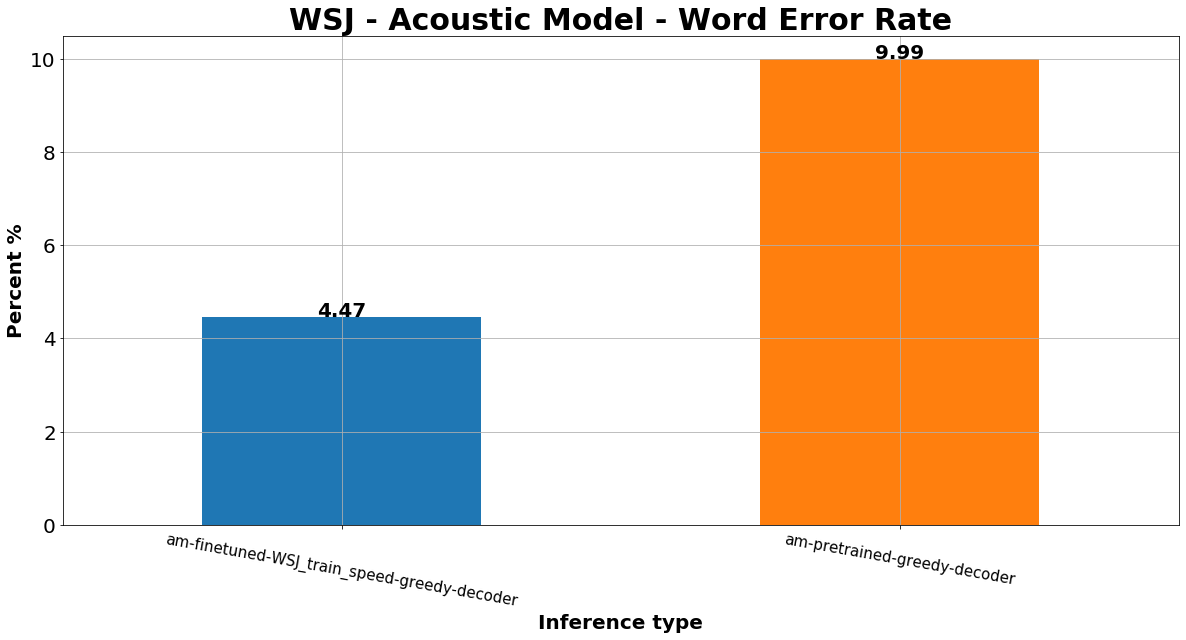

In [21]:
%matplotlib inline
am_wer = barplot_manifest(am_df,'percentWER',"WSJ - Acoustic Model - Word Error Rate", "Inference type","Percent %")

## 5. WER effect of Acoustic training
As shown in the plot, finetuning the acoustic model on our domain data can greatly improve model performance.

In [22]:
am_df.set_index('inference_types', inplace=True)

In [23]:
org = am_df.loc['am-pretrained-greedy-decoder','wer'] # pre-trained model
new = am_df.loc['am-finetuned-WSJ_train_speed-greedy-decoder','wer'] # fine-tuned model

In [24]:
per_decrease = 100*((org-new)/org)
print("Decreased WER by {0:.2f}%".format(per_decrease))

Decreased WER by 55.32%
